In [300]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import pickle
import random
# from torchvision import transforms # no torchvision because we are not working with images but with points
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [301]:
data_file = open("./extended_prepared_dataset.pickle", "rb")
data = pickle.load(data_file)
print(len(data))
print(data[0][1])
# the symbols are one-hot encoded; alpha is the first and epsilon is the last symbol
# first 60 symbols are alpha; second 60 are beta etc.

300
[1. 0. 0. 0. 0.]


In [302]:
# Hyper-parameters 
input_size = 40 # 40 points from the normalized points
hidden_size = 128 
num_classes = 5 # 5 symbols
num_epochs = 2000
learning_rate = 0.001
random_seed = 69
test_split = 0.2
batch_size = 16

In [303]:
class CustomSymbolDataset(Dataset):
    def __init__(self, symbols, labels, transform=None, target_transform=None):
        """
            symbols - a list of tuples where the first 
            element is an array of normalized points and
            the second is the one-hot encoded vector of
            the respective symbol
        """
        self.symbols = symbols
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        symbol = self.symbols[idx]
        label = self.labels[idx]
        if self.transform:
            symbol = self.transform(symbol)
        if self.target_transform:
            label = self.target_transform(label)
        return symbol, label
    
class ToTensor(object):
    """Convert numpy array in sample to Tensors."""
    def __call__(self, sample):
        return torch.from_numpy(sample)
    
def get_coordinates(array: list):
    arr = array.copy()
    # arr.reverse()
    x = [point[0] for point in arr]
    y = [point[1] for point in arr]
    return x, y

In [304]:
symbols = [x[0] for x in data]
labels = [x[1] for x in data]
print(len(symbols), len(labels))

300 300


In [305]:
# Split the data into a train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    symbols, 
    labels, 
    test_size=test_split,
    random_state=random_seed,
    shuffle=True)

print("Train ", len(X_train), len(y_train))
print("Val ", len(X_val), len(y_val))

# Define the train dataset and dataloader
train_dataset = CustomSymbolDataset(X_train, y_train, transform=ToTensor(), target_transform=ToTensor())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)

print(len(train_dataloader))
print(len(val_dataloader))

# Define the validation dataset and dataloader
val_dataset = CustomSymbolDataset(X_val, y_val, transform=ToTensor(), target_transform=ToTensor())
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)

Train  240 240
Val  60 60
15
4


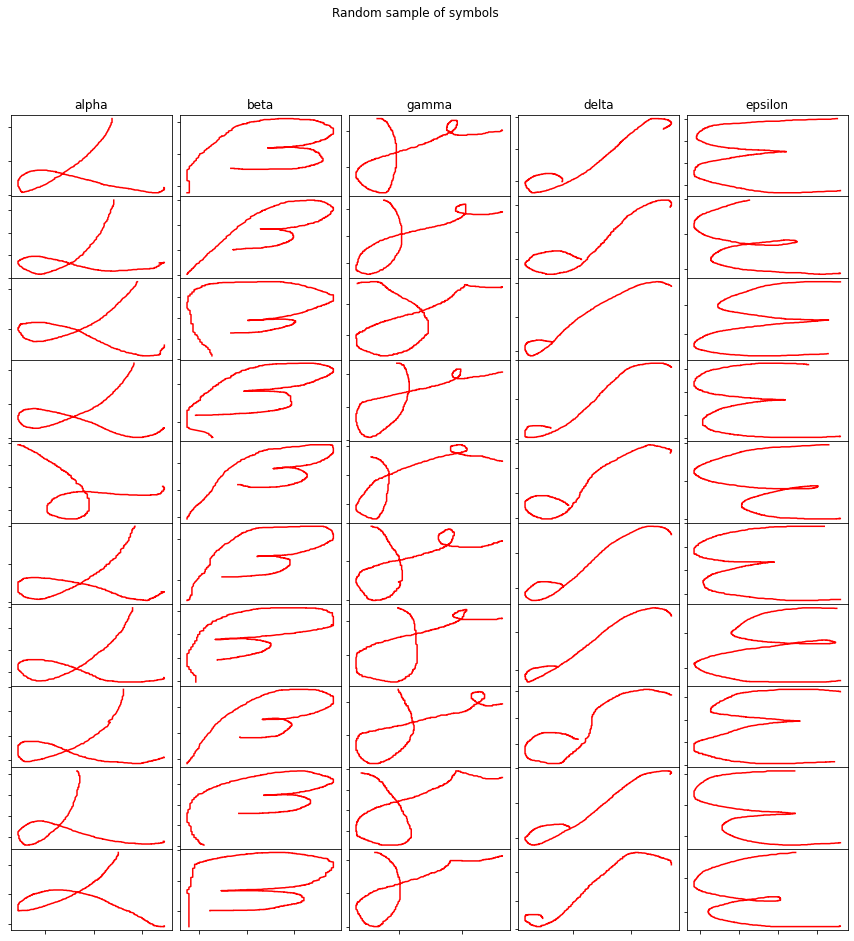

In [331]:
# Loading the raw data
image_per_symbol = 10
raw_data_file = open("raw_dataset.pickle", "rb")
raw_data = pickle.load(raw_data_file)
fig, ax = plt.subplots(image_per_symbol, 5, figsize=(15, 15))
fig.subplots_adjust(wspace=0.05, hspace=0)
fig.suptitle("Random sample of symbols")

# The axis have to be inverted because in the GUI the origin is in the top left corner. 
for i, symb in enumerate(['alpha', 'beta', 'gamma', 'delta', 'epsilon']):
    sample = random.sample(raw_data[i*30:(i+1)*30], image_per_symbol)
    ax[0, i].title.set_text(f"{symb}")
    for j, s in enumerate(sample):
        x, y = get_coordinates(s[0])
        ax[j, i].invert_yaxis()
        ax[j, i].plot(x, y, 'r', markersize=1)
        ax[j, i].set_yticklabels([])
        ax[j, i].set_xticklabels([])

In [161]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.to(torch.float32)
        out = self.l1(x)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.l2(out)
        out = self.relu2(out)
        out = self.l3(out)
        # no activation and no softmax at the end
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [162]:
# Training loop
n_total_steps = len(train_dataloader)
for epoch in range(num_epochs):
    
    for i, (symbols, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()

        # symbols = symbols.reshape(-1, 40).to(device)
        symbols = symbols.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(symbols)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 50 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}]\tLoss: {loss.item():.6f}')

Epoch [50/2000]	Loss: 0.860870
Epoch [100/2000]	Loss: 0.809212
Epoch [150/2000]	Loss: 0.561769
Epoch [200/2000]	Loss: 0.373085
Epoch [250/2000]	Loss: 0.506827
Epoch [300/2000]	Loss: 0.167638
Epoch [350/2000]	Loss: 0.193312
Epoch [400/2000]	Loss: 0.199290
Epoch [450/2000]	Loss: 0.192460
Epoch [500/2000]	Loss: 0.333800
Epoch [550/2000]	Loss: 0.104060
Epoch [600/2000]	Loss: 0.045499
Epoch [650/2000]	Loss: 0.190585
Epoch [700/2000]	Loss: 0.063244
Epoch [750/2000]	Loss: 0.066050
Epoch [800/2000]	Loss: 0.111475
Epoch [850/2000]	Loss: 0.155006
Epoch [900/2000]	Loss: 0.103867
Epoch [950/2000]	Loss: 0.112334
Epoch [1000/2000]	Loss: 0.121045
Epoch [1050/2000]	Loss: 0.050511
Epoch [1100/2000]	Loss: 0.069452
Epoch [1150/2000]	Loss: 0.108682
Epoch [1200/2000]	Loss: 0.106217
Epoch [1250/2000]	Loss: 0.049983
Epoch [1300/2000]	Loss: 0.032912
Epoch [1350/2000]	Loss: 0.101657
Epoch [1400/2000]	Loss: 0.121005
Epoch [1450/2000]	Loss: 0.087070
Epoch [1500/2000]	Loss: 0.046992
Epoch [1550/2000]	Loss: 0.0872

In [212]:
# Test loop
with torch.no_grad():
    # You must call model.eval() to set dropout and batch normalization 
    # layers to evaluation mode before running inference. Failing to do 
    # this will yield inconsistent inference results.
    model.eval()
    correct = 0
    total = 0
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        labels = torch.argmax(labels, dim=1)   # get the label from one-hot encod
        
        correct += (predicted == labels).sum().item()
    print('Test accuracy: {}'.format(correct / total))

Test accuracy: 0.8166666666666667


In [214]:
# Saving the model locally
try:
    PATH = "symbol-recognizer.pt"
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, PATH)
    print(f"Model saved to {PATH}")
except e as Exception:
    print(f"Model not saved. Exception.\n{e}")

Model saved to symbol-recognizer.pt


In [209]:
# This dataset has 150 examples but the prepared has 300 because the dataset doubles
# as we inverse the array as we need to take into account symbols drawn the other way. 
raw_data_file = open("raw_dataset.pickle", "rb")
raw_data = pickle.load(raw_data_file)
print(len(raw_data))
print(raw_data[0][1])

# TODO: Visalize them UPSTAIRS; train a couple of models; save the points as images and train a CNN model; try different architectures; use batch normalization layer and what does it mean???

# TODO: Saznaj kako si spremao ove točke jbg. Ima ih 40. Raspored x0, y0, x1, y1, x2, ...
# the symbols are one-hot encoded; alpha is the first and epsilon is the last symbol
# first 60 symbols are alpha; second 60 are beta etc.

# Loading the model
# TODO

150
alpha
